In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score

%matplotlib inline

In [3]:
os.getcwd()

'/home/matan'

In [4]:
def load_dataset(file_name):
    return pd.read_csv(file_name)


In [5]:
df = load_dataset('~/Projects/h-index-prediction/sientinst_data_merged.csv')

/tmp/ipykernel_24353/1101836751.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_name)


## Data cleansing
Some rows had more than 15 columns, which happend to be a mistake

Data to clean 
* people that do not conduct research 
* people we couldnt find their gender

Columns to edit 
* Position --change to scale from 0 to 4
    0 No Degree
    1 Bachelors Degree
    2 Maters Degree
    3 Doctor Of Philosophy
    4 Proffesor (Part time or Full)
* Categories for contries (with sk label)

Add columns with statistics of each contry such as 
* Human Development Index
* PIZA score 
* GPA

In [6]:
def cleansing(df): # Inplace
    len_before = len(df['Reads'])
    df.drop(df[df['Shanghai_ranking'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Publications'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Reads'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Citations'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Interest score'].str.isnumeric() == False].index, inplace = True)
    len_after = len(df['Reads'])
    print(str(len_before-len_after)+" rows were removed")
    df.to_csv('sientist_data_cleansing')

In [48]:
cleansing(df)
df.head()

0 rows were removed


,Full name,Gender,Position,Nation,Institute,Shanghai_ranking,Depratment,Disciplines,Publications,Citations,Recommendations,Top cited research,Interest score,Reads,h index,URL
0,Thomas Serre,Male,PhD,United States,Brown University,47,"Department of Cognitive, Linguistic and Psycho...",Machine Vision|Object Recognition|Machine Lear...,183,11905,64,HMDB51: A Large Video Database for Human Motio...,6087,33978,40,https://www.researchgate.net/profile/Thomas-Serre
1,Abdullah Chahin,Male,MD,United States,Brown University,47,Division of Infectious Diseases,Sepsis|ICU|Intensive Care Medicine,62,234,5,False alarm reduction in critical care,1379,3586,9,https://www.researchgate.net/profile/Abdullah_...
2,Richard M Mariita,Male,"BEd (Science), MSc (Microbiology) both from Ke...",United States,Brown University,47,Department of Chemistry,Microbiology|Genomics|PCR,39,286,55,Antitubercular and Phytochemical Investigation...,1959,4724,7,https://www.researchgate.net/profile/Richard_M...
3,Sharon Miriam Swartz,Female,"Ph.D., The University of Chicago",United States,Brown University,47,Department of Ecology and Evolutionary Biology,Zoology|Biomechanics|Mammals,152,4510,45,The 'Law of Bone Transformation': A Case of Cr...,2329,37724,39,https://www.researchgate.net/profile/Sharon-Sw...
4,Roberto Zenit,Male,Ph.D.,United States,Brown University,47,Brown School of Engineering,Numerical Simulation|Fluid Mechanics|Fluid Dyn...,235,3444,141,Particle-wall collisions in a viscous fluid,2294,48142,31,https://www.researchgate.net/profile/Roberto-Z...


to find genders of scientists we use the API / Dataset from Facebook https://github.com/philipperemy/name-dataset
using `pip install name-dataset`

In [9]:
from names_dataset import NameDataset, NameWrapper
nd = NameDataset() # uses 3.2 GB of RAM , use with caution 

In [12]:
def find_gender(name):
    try:
        x = nd.search(name)['first_name']['gender']
        if x['Male'] >= x['Female']:
            return 'Male'
        else:
            return 'Female'
    except: 
        return 'NaN'
first_names = df['Full name'].str.split(' ').apply(lambda x: x[0])
genders_list = list()
for name in first_names:
    genders_list.append(find_gender(name))
df['Gender'] = genders_list

the amount of entries to remove (Gender Not defined)

In [44]:
print(str(len(df[df['Gender']=='NaN']))+" sientists were removed (not determied gender)")

2912


In [46]:
df.drop(df[df['Gender'] == "NaN"].index ,inplace = True)
df.to_csv('sientist_data_cleansing_geneder_clear.csv')

In [5]:
df = load_dataset('sientist_data_cleansing_geneder_clear.csv')

/tmp/ipykernel_12668/1101836751.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_name)


in the following cell we remove all people which apear not being a sientists:
that means they have no publications, reads and ect.

In [26]:
try:
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
except:
     print ("")

series_to_remove = df[df['Publications'] + df['Citations'] + df['Recommendations'] + df['Interest score']+
                      df['Reads']+ df['h index'] == 0].index

print(str(len(series_to_remove))+" sientists were removed (apear to not being sientists)")

df.drop(series_to_remove, inplace = False)
df.drop_duplicates()


3051 sientists were removed (apear to not being sientists)


,Full name,Gender,Position,Nation,Institute,Shanghai_ranking,Depratment,Disciplines,Publications,Citations,Recommendations,Top cited research,Interest score,Reads,h index,URL
0,Thomas Serre,Male,PhD,United States,Brown University,47,"Department of Cognitive, Linguistic and Psycho...",Machine Vision|Object Recognition|Machine Lear...,183,11905,64,HMDB51: A Large Video Database for Human Motio...,6087,33978,40,https://www.researchgate.net/profile/Thomas-Serre
1,Abdullah Chahin,Male,MD,United States,Brown University,47,Division of Infectious Diseases,Sepsis|ICU|Intensive Care Medicine,62,234,5,False alarm reduction in critical care,1379,3586,9,https://www.researchgate.net/profile/Abdullah_...
2,Richard M Mariita,Male,"BEd (Science), MSc (Microbiology) both from Ke...",United States,Brown University,47,Department of Chemistry,Microbiology|Genomics|PCR,39,286,55,Antitubercular and Phytochemical Investigation...,1959,4724,7,https://www.researchgate.net/profile/Richard_M...
3,Sharon Miriam Swartz,Female,"Ph.D., The University of Chicago",United States,Brown University,47,Department of Ecology and Evolutionary Biology,Zoology|Biomechanics|Mammals,152,4510,45,The 'Law of Bone Transformation': A Case of Cr...,2329,37724,39,https://www.researchgate.net/profile/Sharon-Sw...
4,Roberto Zenit,Male,Ph.D.,United States,Brown University,47,Brown School of Engineering,Numerical Simulation|Fluid Mechanics|Fluid Dyn...,235,3444,141,Particle-wall collisions in a viscous fluid,2294,48142,31,https://www.researchgate.net/profile/Roberto-Z...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36768,Carolina Herrera,Female,Nan,Chile,University-of-Santiago-Chile,401,Departamento de Economía,Legal Analysis|Human Rights and Democracy|Conf...,0,0,0,Nan,0,0,0,NaN
36769,Luis Tecas,Male,Nan,Chile,University-of-Santiago-Chile,401,Departamento de Lingüística y Literatura,Cognitive Linguistics,0,0,0,Nan,0,0,0,NaN
36770,Jonathan norambuena Caceres,Male,Nan,Chile,University-of-Santiago-Chile,401,Departamento de Biología,Pharmaceutical Development,0,0,0,Nan,0,0,0,NaN
36771,Javiera Pacheco,Female,Nan,Chile,University-of-Santiago-Chile,401,Escuela de Medicina,Neurological Diseases|Neurodegeneration|Neurop...,0,0,0,Nan,0,0,0,NaN


### Ouliers

<AxesSubplot:>

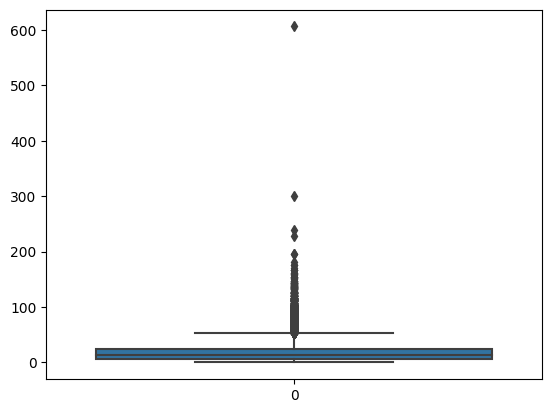

In [35]:
sns.boxplot(df["h index"])

In [34]:
df[df["h index"]>600]

,Full name,Gender,Position,Nation,Institute,Shanghai_ranking,Depratment,Disciplines,Publications,Citations,Recommendations,Top cited research,Interest score,Reads,h index,URL
9265,Cynthia Edenburg,Female,PhD,Israel,The-Open-University-of-Israel,201,"Department of History, Philosophy and Judaic S...",Distance Education|Online Learning|E-Learning,19,65,0,How (not) to murder a king: Variations on a th...,26,338,606,3


In [37]:
df.drop(df[df["h index"]>600].index, inplace = True)

We've search for Cynthia Edenburg, and it seems that her h index is wrongly calcualtely.
So we decide that she's an outlier

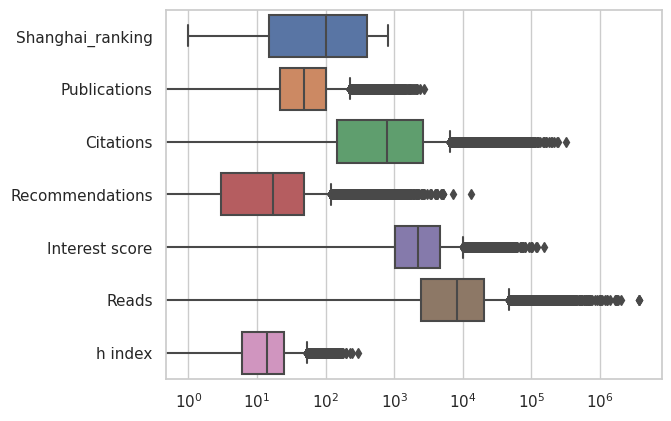

In [47]:
sns.set(style="whitegrid")

# we scale X-axis logaritmically
plt.xscale('log')

sns.boxplot(df, orient="h");

In [42]:
df[df["Reads"]>3500000]

,Full name,Gender,Position,Nation,Institute,Shanghai_ranking,Depratment,Disciplines,Publications,Citations,Recommendations,Top cited research,Interest score,Reads,h index
1705,Goodarz Danaei,Male,Professor (Associate) at Harvard University,United States,Harvard University,1,Department of Global Health and Population,Epidemiologic Studies|Hypertension|Epidemiolog...,306,70185,1306,A comparative risk assessment of burden of dis...,35390,3726175,72
11623,Lital Keinan-Boker,Female,"MD, PhD, MPH",Israel,University-of-Haifa,501,School of Public Health,Cancer|Phytoestrogens|Breast Cancer,297,25504,759,"Worldwide trends in body-mass index, underweig...",13242,3674694,48
27472,Regina M Fisberg,Female,Associate Professor,Brazil,University-of-Sao-Paulo,101,Department of Nutrition (São Paulo),Hypertension|Nutrition|Metabolism,362,6278,429,Global sodium consumption and death from cardi...,3524,3665645,42


In [39]:
try:
    df.drop(["URL"], axis=1, inplace=True)
except:
     print ("")

# EDA

In [61]:
def load_dataset(file_name, target_column):
    df = pd.read_csv(file_name)
    return df.drop([target_column], axis=1), df[target_column].copy()
    

In [62]:
file_name = 'sientist_data_cleansing'
target_col_name = 'h index'

try:
    X, y = load_dataset(file_name, target_col_name)
except Exception as e:
    print ('\tError Message:', str(e))
    raise 

In [63]:
y

0        40
1         9
2         7
3        39
4        31
         ..
28423    32
28424    21
28425    23
28426    32
28427    16
Name: h index, Length: 28428, dtype: int64

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28428 entries, 0 to 28427
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          28428 non-null  int64 
 1   Full name           28428 non-null  object
 2   Gender              28428 non-null  object
 3   Position            28428 non-null  object
 4   Nation              28428 non-null  object
 5   Institute           28428 non-null  object
 6   Shanghai_ranking    28428 non-null  int64 
 7   Depratment          28428 non-null  object
 8   Disciplines         28428 non-null  object
 9   Publications        28428 non-null  int64 
 10  Citations           28428 non-null  int64 
 11  Recommendations     28428 non-null  int64 
 12  Top cited research  28428 non-null  object
 13  Interest score      28428 non-null  int64 
 14  Reads               28428 non-null  int64 
 15  URL                 27219 non-null  object
dtypes: int64(7), object(9)

In [69]:
X.describe(include='all')

,Unnamed: 0,Full name,Gender,Position,Nation,Institute,Shanghai_ranking,Depratment,Disciplines,Publications,Citations,Recommendations,Top cited research,Interest score,Reads,URL
count,28428.000000,28428,28428,28428,28428,28428,28428.000000,28428,28428,28428.000000,28428.000000,28428.000000,28428,28428.000000,2.842800e+04,27219
unique,NaN,28188,3,4997,8,31,NaN,5018,21187,NaN,NaN,NaN,23857,NaN,NaN,27191
top,NaN,Tal Cohen,male,PhD,United States,Weizmann-Institute-of-Science,NaN,Department of Chemistry,Nan,NaN,NaN,NaN,Nan,NaN,NaN,t
freq,NaN,4,27519,6402,10927,1000,NaN,561,5556,NaN,NaN,NaN,3106,NaN,NaN,5
mean,14588.539187,NaN,NaN,NaN,NaN,NaN,177.988040,NaN,NaN,92.198677,3885.976572,49.050725,NaN,3559.091037,1.939902e+04,NaN
std,8547.354880,NaN,NaN,NaN,NaN,NaN,263.455342,NaN,NaN,135.100014,9541.473850,168.683852,NaN,4821.799740,5.865871e+04,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000e+00,NaN
25%,7162.750000,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,19.000000,171.750000,3.000000,NaN,1033.000000,2.034500e+03,NaN
50%,14302.500000,NaN,NaN,NaN,NaN,NaN,24.000000,NaN,NaN,50.000000,1041.500000,15.000000,NaN,2289.000000,7.479000e+03,NaN
75%,22155.250000,NaN,NaN,NaN,NaN,NaN,301.000000,NaN,NaN,110.000000,3544.000000,45.000000,NaN,4917.250000,1.965875e+04,NaN


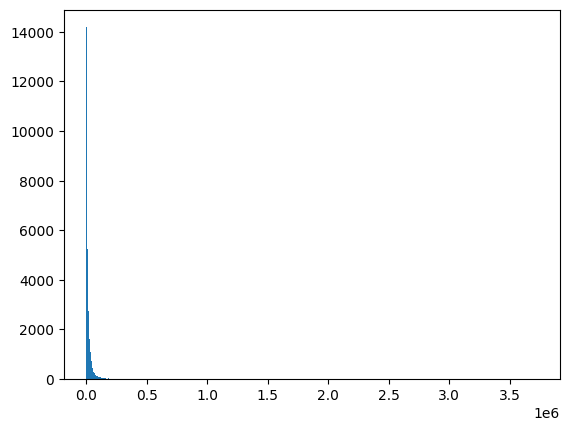

In [67]:
plt.hist(X.Reads, bins=500);